# Feature importance analysis

In this notebook we analyse the importance of each SNP to the model using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) method. 

_Imports and configs_

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from diabnet.analysis import explain_ensemble
# from diabnet.model import load
from diabnet.data import get_feature_names
from diabnet.ensemble import Ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

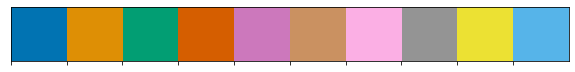

In [3]:
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'font.family': 'monospace'})

In [4]:
SAVE = True
img_formats = ['pdf', 'svg', 'png']  

_load trained ensemble model_

In [5]:
ensemble = Ensemble('../results/models/positive/model-positive-21-adamw-lc7-2021-10-05')

In [6]:
feat_names = get_feature_names("../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv", use_sex=True, use_parents_diagnosis=True)

In [7]:
# DEBUG:
# feat_names[-20:]

In [8]:
# feature attribution using training dataset
e_train = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [9]:
# feature attribution using test dataset
e_test = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [10]:
# def feat_importance(values, age, sex):
#     imp = values.calc_attr(age, sex)
#     # testa se o SNP tem valores 1 ou 2. caso não tenha, sua importancia não pode ser calculada
#     s = {k: [np.mean(imp[k]), np.median(imp[k])] for k in imp if len(imp[k]) > 0} 
#     df = pd.DataFrame.from_dict(s, orient='index')
#     df.rename(columns={0:f'{sex}{age}_mean', 1:f'{sex}{age}_median'}, inplace=True)
#     # df.sort_values(by=0, ascending=False).head(50)
#     return df
    

# Feature Importance

Qual a importância dos SNPs independentemente de outras características (sexo, diagnóstico dos pais, idade*).
*Para torna independente da idade fixamos a idade em 40.

In [11]:
age = 40
sex = 'X' # 'X' significa qualquer sexo

Não há um consenso se a análise de importância das características (feature importance) deve ser feita com os dados de teste ou treinamento. Nós testamos os dois...

In [12]:
df_feat_imp_40_X_train = e_train.feat_importance(40, 'X')


In [13]:
df_feat_imp_40_X_test = e_test.feat_importance(40, 'X')

In [14]:
df_feat_imp_40_X_test

,X40_mean,X40_median
snp_8_133462953,0.071688,0.018125
snp_2_91635413,0.005133,0.000860
snp_9_25963828,0.011724,0.003935
snp_1_17764169,0.011156,0.001656
snp_12_41767967,-0.001865,-0.000104
...,...,...
snp_20_26104019,0.011398,0.002831
snp_20_50189624,-0.005145,-0.001551
snp_1_143276644,0.000003,-0.000033
snp_16_9536673,0.012227,0.003921


No entanto, no conjunto de teste 44 dos 1000 SNPs não possuem o gene base do alelo recessivo (valores 1 ou 2) e consequentemente, não conseguimos atribuir um valor de importância. E como notamos pelo boxplot abaixo, boa parte deles podem ser importantes.

44 SNPs não tem valores no conjunto de teste


<AxesSubplot:ylabel='X40_mean'>

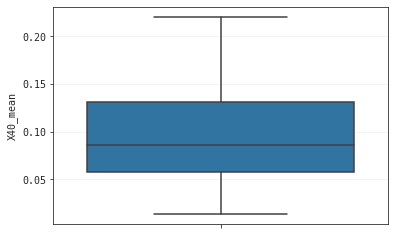

In [15]:
excluded = df_feat_imp_40_X_train[df_feat_imp_40_X_train.index.isin(df_feat_imp_40_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs não tem valores no conjunto de teste")
sns.boxplot(y="X40_mean", data=excluded)

In [16]:
df_feat_imp_40_X = df_feat_imp_40_X_train.join(df_feat_imp_40_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_40_X['SNP'] = df_feat_imp_40_X.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_40_X = df_feat_imp_40_X.sort_values(by="X40_mean_train")
df_feat_imp_40_X # apenas 956 pq 44 dos SNPs não tem valores 1 ou 2 no conjunto de teste 

,X40_mean_train,X40_median_train,X40_mean_test,X40_median_test,SNP
snp_21_11058226,-0.056970,-0.019454,-0.054891,-0.020099,snp_21_11058226
snp_17_15464147,-0.046048,-0.014813,-0.049875,-0.016717,snp_17_15464147
snp_11_89308032,-0.034998,-0.007443,-0.036660,-0.007295,snp_11_89308032
snp_16_82889990,-0.033212,-0.010543,-0.031536,-0.011116,snp_16_82889990
snp_11_68894909,-0.032192,-0.009706,-0.023904,-0.007876,snp_11_68894909
...,...,...,...,...,...
snp_1_209147965,0.192136,0.085002,0.132570,0.017468,snp_1_209147965
snp_3_124845764,0.201556,0.098136,0.164448,0.086452,snp_3_124845764
snp_1_83758864,0.208876,0.090273,0.151397,0.086615,snp_1_83758864
snp_6_121073528,0.264892,0.110995,0.212453,0.048013,snp_6_121073528


Comparando a média e a mediana da importância calculada para os conjuntos de treinamento e teste podemos ver que há uma correlação significativa (como esperado). Logo, optaremos por realizar as análises subsequentes apenas com a importância calculada no conjunto de treinamento.

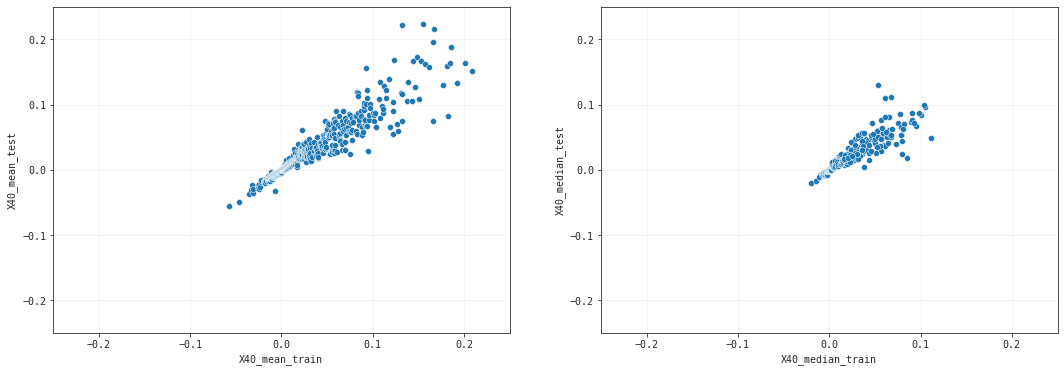

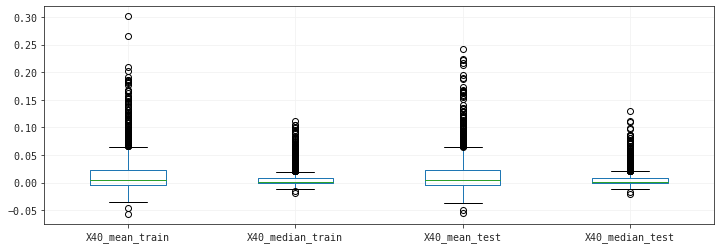

In [17]:
plt.figure(figsize=(18,6));
plt.subplot(121);
sns.scatterplot(x="X40_mean_train", y="X40_mean_test", data=df_feat_imp_40_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.subplot(122);
sns.scatterplot(x="X40_median_train", y="X40_median_test", data=df_feat_imp_40_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.figure(figsize=(12,4));
df_feat_imp_40_X.boxplot();

In [19]:
df_feat_imp_40_X_train.describe()

,X40_mean,X40_median
count,1000.000000,1000.000000
mean,0.022241,0.009548
std,0.044174,0.019929
min,-0.056970,-0.019454
25%,-0.003918,-0.000475
50%,0.005540,0.000888
75%,0.028493,0.009711
max,0.301255,0.110995


In [20]:
df_feat_imp_40_X_train["chr"] = [int(s.split('_')[1]) for s in df_feat_imp_40_X_train.index]
df_feat_imp_40_X_train["pos"] = [float(s.split('_')[2]) for s in df_feat_imp_40_X_train.index]
df_feat_imp_40_X_train

,X40_mean,X40_median,chr,pos
snp_8_133462953,0.057046,0.018523,8,133462953.0
snp_2_91635413,0.005587,0.000888,2,91635413.0
snp_9_25963828,0.010934,0.003269,9,25963828.0
snp_1_17764169,0.011215,0.001770,1,17764169.0
snp_12_41767967,-0.002257,-0.000111,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.011662,0.003171,20,26104019.0
snp_20_50189624,-0.004948,-0.001568,20,50189624.0
snp_1_143276644,-0.000676,-0.000054,1,143276644.0
snp_16_9536673,0.010117,0.002589,16,9536673.0


In [21]:
df_feat_imp_40_X_train

,X40_mean,X40_median,chr,pos
snp_8_133462953,0.057046,0.018523,8,133462953.0
snp_2_91635413,0.005587,0.000888,2,91635413.0
snp_9_25963828,0.010934,0.003269,9,25963828.0
snp_1_17764169,0.011215,0.001770,1,17764169.0
snp_12_41767967,-0.002257,-0.000111,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.011662,0.003171,20,26104019.0
snp_20_50189624,-0.004948,-0.001568,20,50189624.0
snp_1_143276644,-0.000676,-0.000054,1,143276644.0
snp_16_9536673,0.010117,0.002589,16,9536673.0


In [22]:
df_dataset_train = pd.read_csv("../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

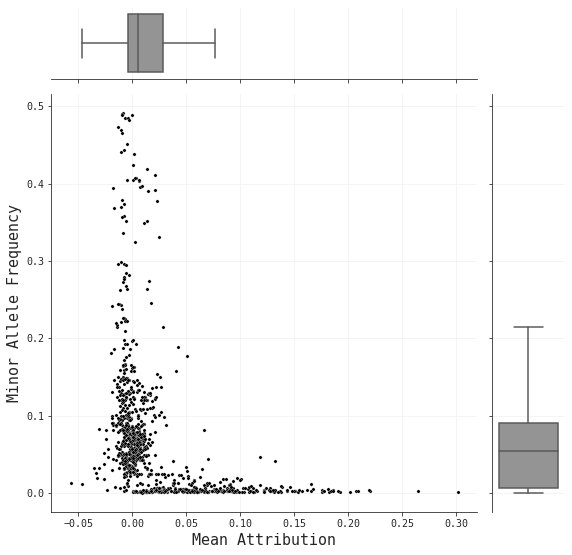

In [162]:
# fig = plt.figure(figsize=(8,8))
# plt.scatter(df_feat_imp_40_X_train["X40_mean"],[np.mean(df_dataset_train[i])/2 for i in df_feat_imp_40_X_train.index], marker='.', s=11, c='k')
g = sns.JointGrid(x=df_feat_imp_40_X_train["X40_mean"],
                  y=[np.mean(df_dataset_train[i])/2 for i in df_feat_imp_40_X_train.index])
g.plot_joint(sns.scatterplot, color='k', s=11)
g.plot_marginals(sns.boxplot, color=colors[7],showfliers=False)
# plt.ylabel('SNP - minor allele frequency', fontsize=15)
g.set_axis_labels(xlabel='Mean Attribution', ylabel='Minor Allele Frequency', fontsize=15)
# plt.ylim(-0.01, 0.51)
# plt.xlim(-0.11, 0.36)
g.figure.set_size_inches(8, 8)
if SAVE:
    for img_format in img_formats:
        g.savefig(f"images/notebook7-freq-attr.{img_format}", bbox_inches="tight")

O gráfico da atribuição dos SNPs separado por cromossomo (abaixo) mostra que os chr 1 e 3 

<AxesSubplot:xlabel='chr', ylabel='X40_mean'>

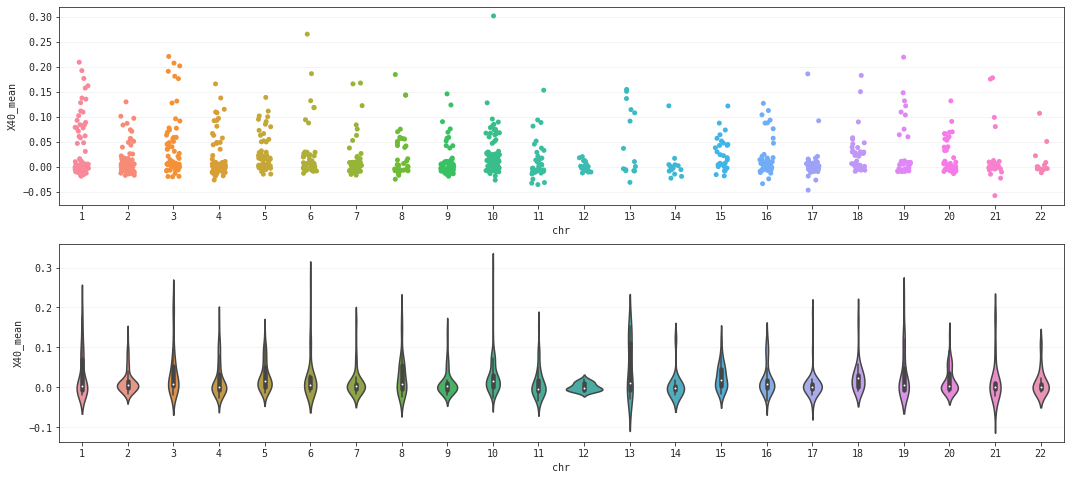

In [26]:
fig = plt.figure(figsize=(18,8))
plt.subplot(211)
sns.stripplot(x="chr", y="X40_mean", data=df_feat_imp_40_X_train, jitter=0.15)
plt.subplot(212)
sns.violinplot(x="chr", y="X40_mean", data=df_feat_imp_40_X_train, whis=np.inf)

In [27]:
# chr lengths from http://www.insilicase.com/Web/Chromlen.aspx. we increased the lengths by 5% to 
# reduce points that superpose the vertical lines separating chromosomes
# chr_lenghts = [
#     247249719*1.05, 
#     242951149*1.05,
#     199501827*1.05,
#     191273063*1.05,
#     180857866*1.05,
#     170899992*1.05,
#     158821424*1.05,
#     146274826*1.05,
#     140273252*1.05,
#     135374737*1.05,
#     134452384*1.05,
#     132349534*1.05,
#     114142980*1.05,
#     106368585*1.05,
#     100338915*1.05,
#     88827254*1.05,
#     78774742*1.05,
#     76117153*1.05,
#     63811651*1.05,
#     62435964*1.05,
#     46944323*1.05,
#     49691432*1.05,
#     # 154913754, X
#     # 57772954, Y 
# ]
chr_lenghts = [
    247249719+2e7, 
    242951149+2e7,
    199501827+2e7,
    191273063+2e7,
    180857866+2e7,
    170899992+2e7,
    158821424+2e7,
    146274826+2e7,
    140273252+2e7,
    135374737+2e7,
    134452384+2e7,
    132349534+2e7,
    114142980+2e7,
    106368585+2e7,
    100338915+2e7,
    88827254+2e7,
    78774742+2e7,
    76117153+2e7,
    63811651+2e7,
    62435964+2e7,
    46944323+2e7,
    49691432+2e7,
    # 154913754, X
    # 57772954, Y 
]
cum_pos = np.insert(np.cumsum(chr_lenghts), 0, 0)
df_feat_imp_40_X_train['cumulative_pos'] = [cum_pos[chr-1] + pos + 1e7 for chr, pos in zip(df_feat_imp_40_X_train.chr, df_feat_imp_40_X_train.pos)]

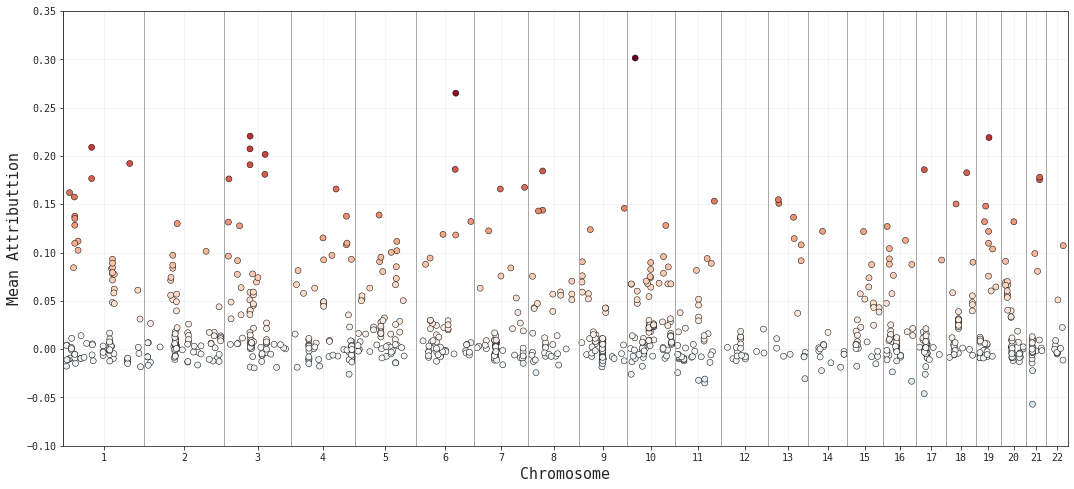

In [163]:
fig = plt.figure(figsize=(18,8))
sns.scatterplot(x='cumulative_pos',
            y='X40_mean', 
            data=df_feat_imp_40_X_train,
            hue="X40_mean", 
            hue_norm=(-0.3,0.3), palette="RdBu_r", edgecolor="k")
plt.legend().remove()
plt.vlines(cum_pos,-0.35,0.35, color='darkgrey', lw=1)
plt.ylim(-0.1,0.35);
plt.xlim(0, np.sum(chr_lenghts));
plt.ylabel("Mean Attributtion", fontsize=15);
plt.xticks(cum_pos[1:] - np.array(chr_lenghts)/2, [f'{i+1}' for i in range(22)])
plt.xlabel("Chromosome", fontsize=15);
plt.savefig('./images/chromosomes_attribution.pdf')
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook7-chromosomes-attribution.{img_format}", bbox_inches="tight")

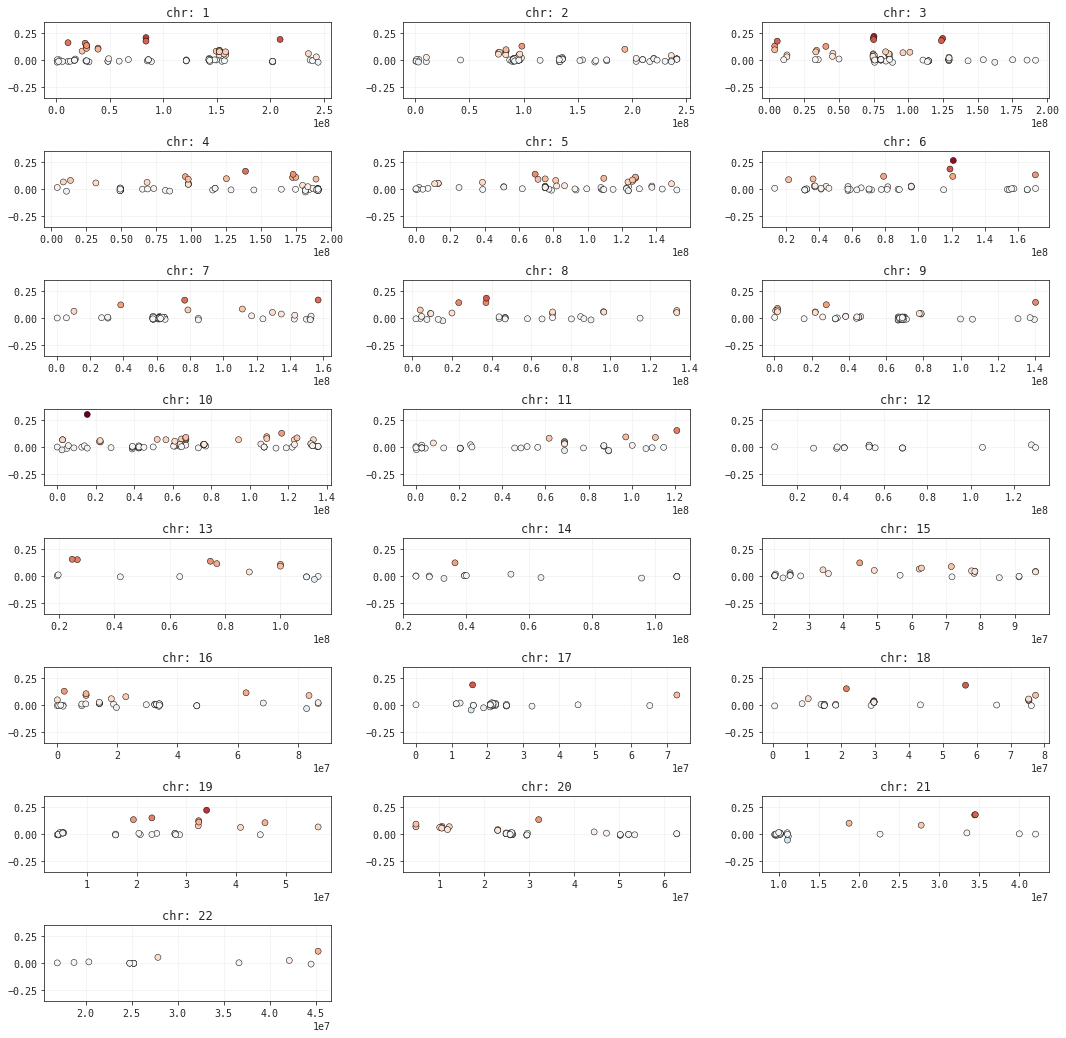

In [29]:
fig = plt.figure(figsize=(18,18))
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', 
                    y="X40_mean", 
                    data=df_feat_imp_40_X_train[df_feat_imp_40_X_train["chr"]==i+1], 
                    hue="X40_mean", 
                    hue_norm=(-0.3,0.3), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.35,0.35)
    plt.ylabel("")
    plt.xlabel("")



NameError: name 'df_feat_imp_50_X_train' is not defined

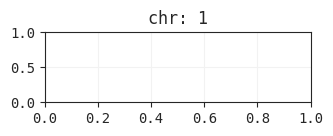

In [30]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', y="X40_median", data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], hue="X50_mean", hue_norm=(-0.22,0.22), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.15,0.15)
    plt.ylabel("")
    plt.xlabel("")

In [ ]:
selection = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_mean'])> 2*df_feat_imp_50_X_train['X50_mean'].std()]

In [ ]:
# selection.sort_values(by='X50_mean').to_csv("feature_importance.csv")

In [ ]:
selection.sort_values(by='X50_mean', ascending=False)

In [ ]:
selection_median = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_median'])> 2*df_feat_imp_50_X_train['X50_median'].std()]

In [ ]:
selection_median.sort_values(by='X50_median', ascending=False)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(211)
# sns.stripplot(x="chr", y="X50_mean", data=selection, jitter=0.15)
sns.swarmplot(x="chr", y="X50_mean", data=selection)
plt.subplot(212)
# sns.barplot(x="chr", y="X50_mean", data=selection)
sns.countplot(x="chr", data=selection)

## Análise por sexo

In [ ]:
# feature importance - M x F
# age: 50, set: test

In [176]:
df_feat_imp_40_M_train = e_train.feat_importance(40, 'M')
df_feat_imp_40_F_train = e_train.feat_importance(40, 'F')

In [177]:
df_feat_imp_50_M_train = e_train.feat_importance(50, 'M')
df_feat_imp_50_F_train = e_train.feat_importance(50, 'F')

In [178]:
df_feat_imp_40_FM_train = df_feat_imp_40_M_train.join(df_feat_imp_40_F_train, how='inner')
df_feat_imp_40_FM_train

,M40_mean,M40_median,F40_mean,F40_median
snp_8_133462953,0.059045,0.020984,0.055906,0.017067
snp_2_91635413,0.005004,0.000823,0.006157,0.000956
snp_9_25963828,0.010913,0.003089,0.011000,0.003465
snp_1_17764169,0.010874,0.001675,0.011517,0.001891
snp_12_41767967,-0.002127,-0.000107,-0.002416,-0.000118
...,...,...,...,...
snp_20_26104019,0.012099,0.003355,0.011365,0.003037
snp_20_50189624,-0.005229,-0.001763,-0.004754,-0.001450
snp_1_143276644,-0.000626,-0.000053,-0.000720,-0.000056
snp_16_9536673,0.010262,0.002631,0.009970,0.002521


In [183]:
df_feat_imp_50_FM_train = df_feat_imp_50_M_train.join(df_feat_imp_50_F_train, how='inner')
df_feat_imp_50_FM_train

,M50_mean,M50_median,F50_mean,F50_median
snp_8_133462953,0.020249,0.005670,0.019737,0.004888
snp_2_91635413,0.008754,0.002897,0.009026,0.002951
snp_9_25963828,0.014439,0.008073,0.015390,0.008407
snp_1_17764169,0.018716,0.007789,0.018624,0.007782
snp_12_41767967,-0.002429,-0.000940,-0.003175,-0.000853
...,...,...,...,...
snp_20_26104019,0.020983,0.011418,0.020010,0.010540
snp_20_50189624,-0.009715,-0.005784,-0.009151,-0.005415
snp_1_143276644,-0.001102,-0.000233,-0.001344,-0.000258
snp_16_9536673,0.005548,0.000750,0.004243,0.000626


In [225]:
df_feat_imp_40_FM_train_selection = df_feat_imp_40_FM_train[abs((df_feat_imp_40_FM_train['M40_mean']+df_feat_imp_40_FM_train['F40_mean']))/2 > 2*min(df_feat_imp_40_FM_train['F40_mean'].std(), df_feat_imp_40_FM_train['M40_mean'].std())]
# df_feat_imp_40_FM_train_selection = df_feat_imp_40_FM_train[abs((df_feat_imp_40_FM_train['M40_mean']+df_feat_imp_40_FM_train['F40_mean']))/2 > 0]
df_feat_imp_40_FM_train_selection['SNP'] = df_feat_imp_40_FM_train_selection.index
df_feat_imp_40_FM_train_selection['delta'] = df_feat_imp_40_FM_train_selection['M40_mean'] - df_feat_imp_40_FM_train_selection['F40_mean']
df_feat_imp_40_FM_train_selection['mean_attr'] = (df_feat_imp_40_FM_train_selection['M40_mean'] + df_feat_imp_40_FM_train_selection['F40_mean'])/2

<ipython-input-225-a992a8e1fb8c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-a992a8e1fb8c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-a992a8e1fb8c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [226]:
df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 2*min(df_feat_imp_50_FM_train['F50_mean'].std(), df_feat_imp_50_FM_train['M50_mean'].std())]
# df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 0]
df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index
df_feat_imp_50_FM_train_selection['delta'] = df_feat_imp_50_FM_train_selection['M50_mean'] - df_feat_imp_50_FM_train_selection['F50_mean']
df_feat_imp_50_FM_train_selection['mean_attr'] = (df_feat_imp_50_FM_train_selection['M50_mean'] + df_feat_imp_50_FM_train_selection['F50_mean'])/2

<ipython-input-226-5673af825417>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-226-5673af825417>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-226-5673af825417>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
df_feat_imp_40_FM_train_selection.sort_values(by='delta', ascending=False)

,M40_mean,M40_median,F40_mean,F40_median,SNP,delta,mean_attr
snp_21_34424410,0.264273,0.183118,0.116273,0.049976,snp_21_34424410,0.148001,0.190273
snp_2_98333598,0.196988,0.116346,0.100456,0.054498,snp_2_98333598,0.096532,0.148722
snp_1_158166397,0.132615,0.059506,0.068554,0.027144,snp_1_158166397,0.064061,0.100584
snp_6_120756365,0.155460,0.091483,0.091856,0.056627,snp_6_120756365,0.063604,0.123658
snp_10_108808535,0.131024,0.056154,0.069139,0.031796,snp_10_108808535,0.061885,0.100082
...,...,...,...,...,...,...,...
snp_3_3782668,0.059128,0.020430,0.166110,0.049555,snp_3_3782668,-0.106982,0.112619
snp_19_32543912,0.061484,0.018881,0.173106,0.054691,snp_19_32543912,-0.111623,0.117295
snp_13_74682115,0.087263,0.015537,0.217430,0.066701,snp_13_74682115,-0.130167,0.152346
snp_21_18746599,0.031399,0.011222,0.166638,0.058973,snp_21_18746599,-0.135238,0.099018


<AxesSubplot:xlabel='delta', ylabel='mean_attr'>

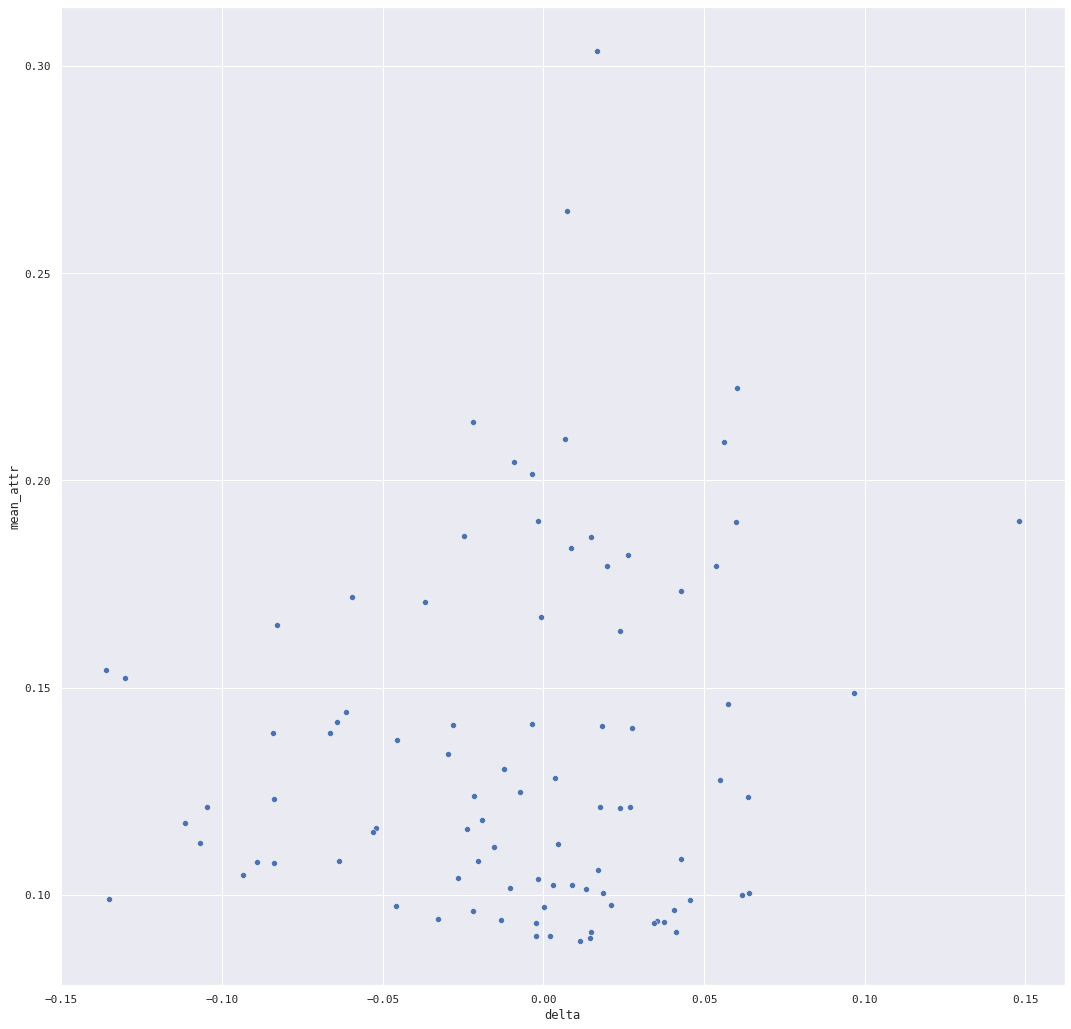

In [317]:
fig = plt.figure(figsize=(18,18))
# plot_arrows(df_tmp_gender_diff)
sns.scatterplot(x='delta', y='mean_attr', data=df_feat_imp_40_FM_train_selection, sizes=(100, 100))
# sns.scatterplot(x='delta', y='mean_attr', data=df_feat_imp_50_FM_train_selection, sizes=(100, 100))


In [238]:
df_tmp_gender_diff = df_feat_imp_50_FM_train_selection.join(df_feat_imp_40_FM_train_selection, how='inner', lsuffix='50', rsuffix='40')

In [296]:
def plot_arrows(df):
    x = df['delta40'].values
    y = df['mean_attr40'].values
    dx = df['delta50'].values - df['delta40'].values
    dy = df['mean_attr50'].values - df['mean_attr40'].values
    alphas = np.abs(dx)/abs(np.max(dx))
    print(np.min(dx))
    for i in range(len(x)):
        plt.arrow(x[i], y[i], dx[i], dy[i], color='k', alpha=alphas[i], lw=1, length_includes_head=True)
           

-0.10899063930555174


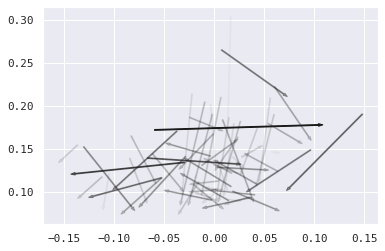

In [287]:
plot_arrows(df_tmp_gender_diff)

In [318]:
df_tmp_gender_diff.sort_values(by='delta50')

,M50_mean,M50_median,F50_mean,F50_median,SNP50,delta50,mean_attr50,M40_mean,M40_median,F40_mean,F40_median,SNP40,delta40,mean_attr40
snp_6_170653258,0.060659,0.018644,0.212909,0.110470,snp_6_170653258,-0.152251,0.136784,0.086232,0.046818,0.222405,0.088508,snp_6_170653258,-0.136172,0.154318
snp_19_19365233,0.051579,0.018384,0.190161,0.105276,snp_19_19365233,-0.138582,0.120870,0.119242,0.054818,0.148833,0.042422,snp_19_19365233,-0.029591,0.134038
snp_19_32543912,0.028484,0.004203,0.161609,0.052823,snp_19_32543912,-0.133124,0.095046,0.061484,0.018881,0.173106,0.054691,snp_19_32543912,-0.111623,0.117295
snp_4_172578583,0.034048,0.009940,0.155052,0.053146,snp_4_172578583,-0.121004,0.094550,0.090208,0.045097,0.142190,0.055014,snp_4_172578583,-0.051982,0.116199
snp_19_32504936,0.027856,0.005112,0.138147,0.042420,snp_19_32504936,-0.110292,0.083001,0.069066,0.020409,0.173610,0.055381,snp_19_32504936,-0.104544,0.121338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
snp_6_121073528,0.248247,0.104913,0.178505,0.071856,snp_6_121073528,0.069742,0.213376,0.268699,0.086636,0.261379,0.136415,snp_6_121073528,0.007320,0.265039
snp_21_34424410,0.142053,0.090868,0.066981,0.015384,snp_21_34424410,0.075072,0.104517,0.264273,0.183118,0.116273,0.049976,snp_21_34424410,0.148001,0.190273
snp_4_138909352,0.200439,0.113484,0.116085,0.054696,snp_4_138909352,0.084354,0.158262,0.206216,0.143774,0.152417,0.101681,snp_4_138909352,0.053798,0.179317
snp_19_34109339,0.210778,0.116638,0.116106,0.048115,snp_19_34109339,0.094672,0.163442,0.252390,0.102175,0.192212,0.110698,snp_19_34109339,0.060178,0.222301


(-2.0, 2.0)

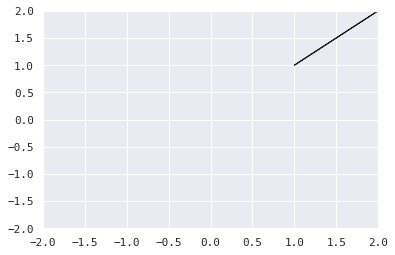

In [254]:

plt.xlim(-2,2)
plt.ylim(-2,2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

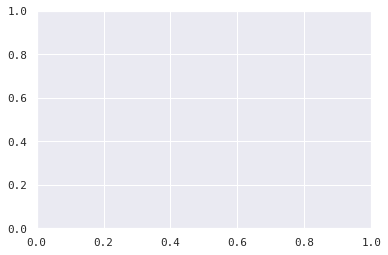

In [239]:
plt.arrow(df_tmp_gender_diff['delta40'].values, df_tmp_gender_diff['mean_attr40'].values, df_tmp_gender_diff['delta50'].values, df_tmp_gender_diff['mean_attr50'].values)

(-0.2, 0.35)

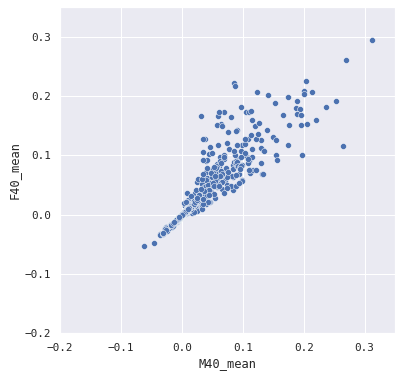

In [179]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M40_mean", y="F40_mean", data=df_feat_imp_40_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

(-0.2, 0.35)

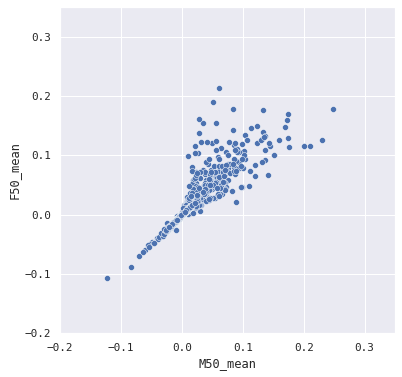

In [190]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_mean", y="F50_mean", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [ ]:
# r² para os snps x sexo

(-0.2, 0.35)

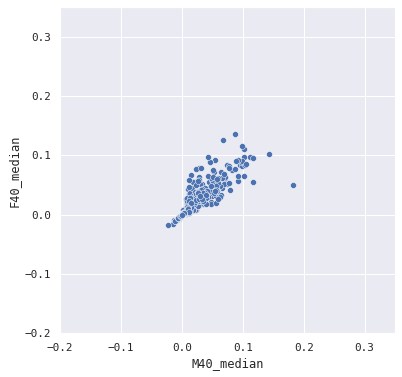

In [180]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M40_median", y="F40_median", data=df_feat_imp_40_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [182]:
df_feat_imp_50_FM_train.sort_values(by="F40_mean").tail(20)

NameError: name 'df_feat_imp_50_FM_train' is not defined

In [ ]:
df_feat_imp_40_FM_train.to_csv("feat_importance_trainset_FM40_lc7-2021-10-05.csv")

In [185]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 0.05]
df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_FM_train_selection.sort_values(by="M50_mean")

<ipython-input-185-b3cbf51b0057>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,M50_mean,M50_median,F50_mean,F50_median,SNP
snp_17_15464147,-0.122788,-0.068198,-0.106112,-0.063339,snp_17_15464147
snp_21_11058226,-0.083686,-0.056430,-0.087411,-0.050819,snp_21_11058226
snp_11_89308032,-0.071195,-0.039684,-0.070252,-0.037654,snp_11_89308032
snp_11_89308027,-0.063839,-0.030156,-0.063528,-0.029488,snp_11_89308027
snp_16_82889990,-0.060559,-0.040303,-0.059326,-0.038795,snp_16_82889990
...,...,...,...,...,...
snp_9_140296542,0.176414,0.089314,0.114787,0.039742,snp_9_140296542
snp_4_138909352,0.200439,0.113484,0.116085,0.054696,snp_4_138909352
snp_19_34109339,0.210778,0.116638,0.116106,0.048115,snp_19_34109339
snp_17_15868329,0.229710,0.071392,0.125517,0.051322,snp_17_15868329


In [188]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
df_feat_imp_40_FM_train_selection = df_feat_imp_40_FM_train[abs((df_feat_imp_40_FM_train['M40_mean']+df_feat_imp_40_FM_train['F40_mean']))/2 > 0.05]
df_feat_imp_40_FM_train_selection['SNP'] = df_feat_imp_40_FM_train_selection.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_40_FM_train_selection.sort_values(by="M40_mean")

<ipython-input-188-ca4add077557>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,M40_mean,M40_median,F40_mean,F40_median,SNP
snp_21_11058226,-0.061925,-0.022681,-0.052276,-0.016812,snp_21_11058226
snp_21_18746599,0.031399,0.011222,0.166638,0.058973,snp_21_18746599
snp_3_33376660,0.034066,0.007441,0.105859,0.025718,snp_3_33376660
snp_10_22347127,0.034512,0.011484,0.069000,0.022367,snp_10_22347127
snp_3_3745392,0.034876,0.013422,0.126839,0.036439,snp_3_3745392
...,...,...,...,...,...
snp_1_209147965,0.237343,0.094720,0.181232,0.083380,snp_1_209147965
snp_19_34109339,0.252390,0.102175,0.192212,0.110698,snp_19_34109339
snp_21_34424410,0.264273,0.183118,0.116273,0.049976,snp_21_34424410
snp_6_121073528,0.268699,0.086636,0.261379,0.136415,snp_6_121073528


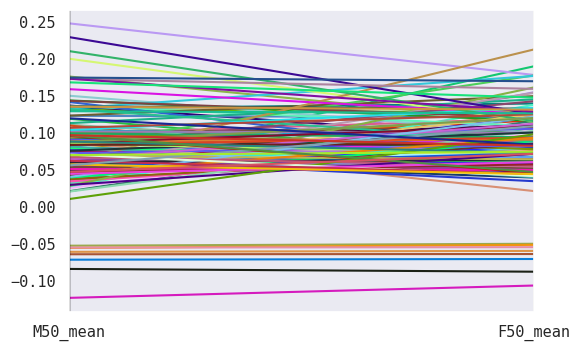

In [186]:
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_50_FM_train_selection, 'SNP', cols=['M50_mean', 'F50_mean'] ).legend().remove() 

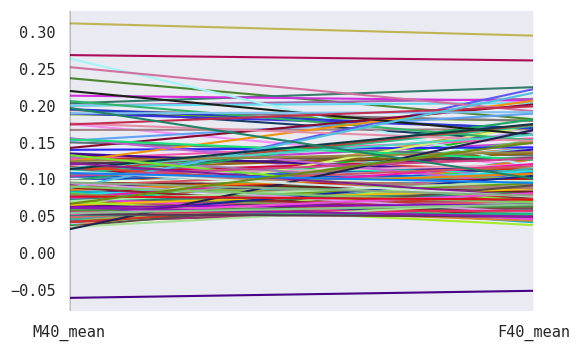

In [189]:
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_40_FM_train_selection, 'SNP', cols=['M40_mean', 'F40_mean'] ).legend().remove() 

# SNP Attribution - Lifelong variability

In [31]:
df_feat_imp_by_age_train = e_train.feat_importance( 20, 'X') 
for age in range(30, 90, 10):
    df_feat_imp_by_age_train = df_feat_imp_by_age_train.join(e_train.feat_importance( age, 'X'),how='inner')

In [32]:
mask = np.array([(abs(df_feat_imp_by_age_train[f'X{age}_mean']) > 2*df_feat_imp_by_age_train[f'X{age}_mean'].std()).values for age in [20,30,40,50,60,70,80]])
count = np.sum(mask, axis=1)
mask = np.sum(mask, axis=0)
mask = mask > 2

In [33]:
# 105 snps with at least 2 ages where feat_importante > 2*std 
mask.sum()

105

In [167]:
# mean

df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[mask]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
df_feat_imp_by_age_train_selection['mean_age'] =  (df_feat_imp_by_age_train_selection['X40_mean'] - df_feat_imp_by_age_train_selection['X50_mean'])/df_feat_imp_by_age_train_selection['X50_mean']
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train_selection.sort_values(by='mean_age')
df_feat_imp_by_age_train_selection.loc[df_feat_imp_by_age_train_selection.iloc[order_cluster[:7]].index, 'cluster'] = 1
df_feat_imp_by_age_train_selection.loc[df_feat_imp_by_age_train_selection.iloc[order_cluster[7:64]].index, 'cluster'] = -1
df_feat_imp_by_age_train_selection.loc[df_feat_imp_by_age_train_selection.iloc[order_cluster[64:]].index, 'cluster'] = 0
 

<ipython-input-167-52c85cd2b72d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-167-52c85cd2b72d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



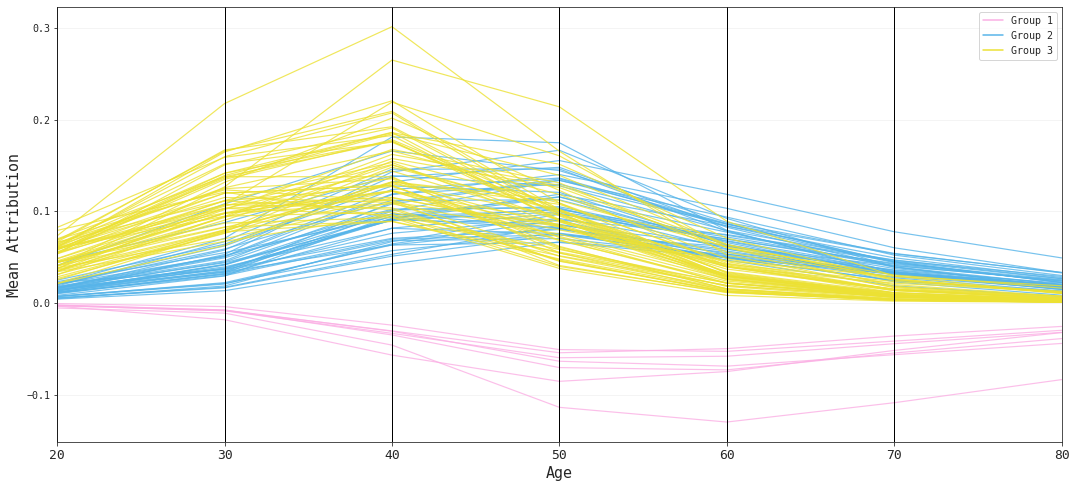

In [168]:
fig = plt.figure(figsize=(18,8))
kwargs = {'lw':1.2, 'alpha':0.8}
ax = parallel_coordinates(df_feat_imp_by_age_train_selection , 'cluster', color=[colors[6], colors[9], colors[8]], cols=[i for i in df_feat_imp_by_age_train.columns if '_mean' in i], **kwargs) 
ax.legend(['Group 1', 'Group 2', 'Group 3'])
ax.set_ylabel('Mean Attribution', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
ax.set_xticklabels([20, 30, 40, 50, 60, 70, 80], fontsize=13);
ax.grid()
import matplotlib.lines as mlines
# blue_line = mlines.Line2D([], [], color='blue', label='Blue')
# red_line = mlines.Line2D([], [], color='red', label='Red')
plt.legend(handles=
           [mlines.Line2D([], [], color=colors[6], label='Group 1'),
           mlines.Line2D([], [], color=colors[9], label='Group 2'),
           mlines.Line2D([], [], color=colors[8], label='Group 3')])
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook7-attr-ages.{img_format}", bbox_inches="tight")

In [170]:
snp_annot = pd.read_csv('../data/SNP_ANNOTATION.csv')
# snp_annot.columns
# snp_annot[['id', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']]

In [171]:
df_annot = df_feat_imp_by_age_train_selection.join(snp_annot[['id', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].set_index('id'))
df_annot.fillna('-', inplace=True)

[8, 0, 2, 1, 3, 4, 5, 47, 49, 51, 59, 58, 62, 65, 54, 57, 52, 53, 55, 50, 56, 70, 67, 68, 66, 60, 61, 73, 81, 71, 69, 72, 64, 78, 84, 86, 77, 87, 91, 92, 94, 88, 89, 80, 85, 76, 79, 63, 82, 83, 74, 75, 95, 97, 90, 93, 98, 102, 103, 99, 100, 104, 96, 101, 11, 7, 9, 6, 10, 45, 48, 44, 46, 40, 42, 37, 36, 38, 39, 41, 43, 15, 12, 13, 23, 14, 21, 22, 31, 19, 24, 18, 16, 17, 20, 30, 26, 28, 32, 34, 29, 35, 33, 25, 27]


<Figure size 576x936 with 0 Axes>

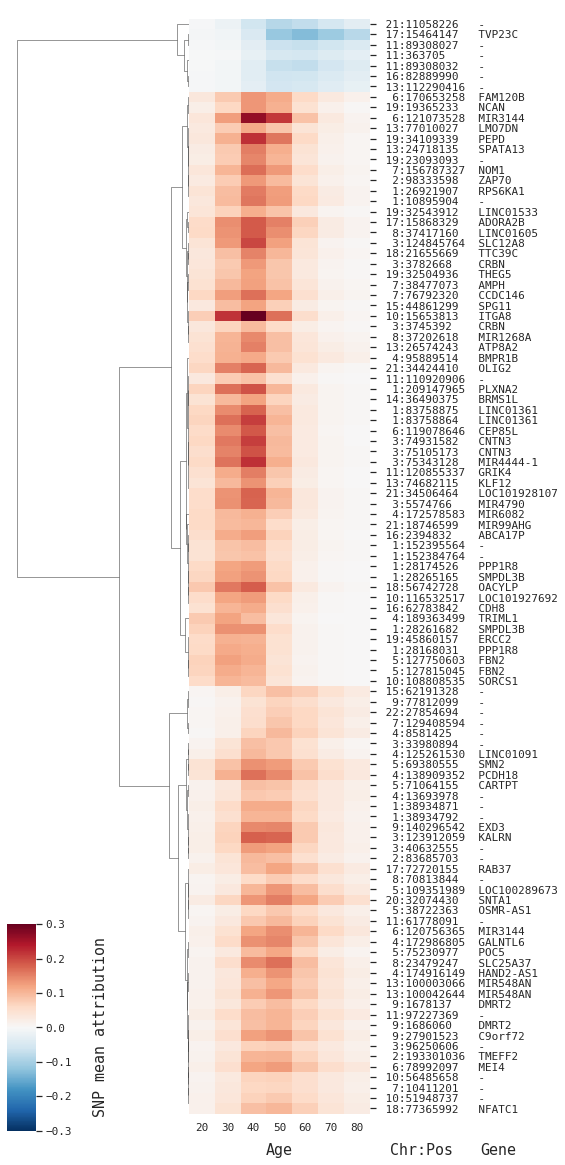

In [174]:
def plot_mat(df):
    c = [c for c in df.columns if '_mean' in c]
    abs_max = np.max(np.abs(df[c].values))
    fig = plt.figure(figsize=(8,13))
    sns.set(font="monospace")
    g = sns.clustermap(
        df[c],# Ignore non-snp data
        cmap="RdBu_r",
        vmin=-abs_max, 
        vmax=abs_max,
        dendrogram_ratio=(.5,.01),
        metric="correlation", 
        method="average",
        col_cluster=False,
        figsize=(8,16),
        cbar_pos=(0.021, 0.013, .05, .18),
        yticklabels=[f"{snp[0].split('_')[1].rjust(3)}:{snp[0].split('_')[2].ljust(10)} {snp[1].ljust(12)}" for snp in df[['SNP','Gene.refGene']].values],
        # yticklabels=[f"{snp[0].split('_')[1].rjust(3)}:{snp[0].split('_')[2].ljust(10)}|{snp[1].ljust(15)}|{snp[2].ljust(13)}|{snp[3].ljust(13)}|{snp[4].ljust(11)}" for snp in df[['SNP', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].values],
        xticklabels=[20,30,40,50,60,70,80], 
 
    )
    print(g.dendrogram_row.reordered_ind)
    plt.text(5.1,-0.37, "Age", fontsize=15)
    plt.text(7.7,-0.37, "Chr:Pos", fontsize=15)
    plt.text(9.6,-0.37, "Gene", fontsize=15)
    plt.text(1.5,-0.25, "SNP mean attribution", fontsize=15, rotation=90)
    # g.savefig("images/notebook7-cluster-simple.pdf")
    # plt.text(4.15,-0.37, "Age", fontsize=15)
    # plt.text(0.7,-0.18, "SNP mean attribution", fontsize=15, rotation=90)
    # g.savefig("images/notebook7-cluster-complete.pdf")

plot_mat(df_annot)


In [170]:
#####################################################################################

<ipython-input-69-142dff17a441>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index


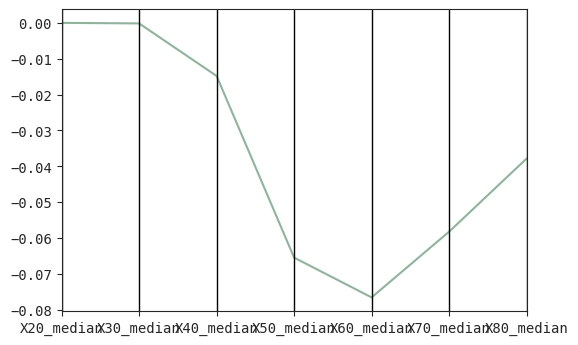

In [69]:
# median
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[abs(df_feat_imp_by_age_train['X80_median']) > 0.02]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'median' in i]).legend().remove() 

In [70]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
# tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.04]
# tmp['SNP'] = tmp.index
# # parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
# tmp.sort_values(by="M50_mean")

In [71]:
# fig = plt.figure(dpi=100)
# parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'])

In [72]:
# feat_imp_by_age = feat_importance(e_test, 20, 'X') 
# for age in range(30, 90, 10):
#     feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')
    

In [73]:
# [i for i in feat_imp_by_age.columns if 'mean' in i]

In [74]:
# tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
# tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'mean' in i])

<AxesSubplot:>

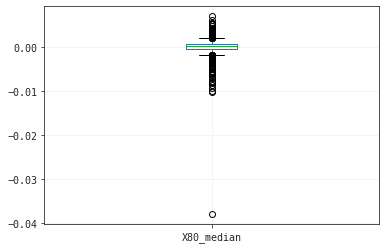

In [75]:
df_feat_imp_by_age_train[['X80_median']].boxplot()

In [76]:
feat_imp_M50.sort_values(by=0, ascending=False).head(50)

NameError: name 'feat_imp_M50' is not defined

In [ ]:
imp = e_test.calc_attr(20, 'X', samples_per_model=1)

In [ ]:
s

In [ ]:
dfnew.sort_values(by=0, ascending=True).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(s, orient='index')

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
import numpy as np
np.mean(df.values, axis=0)

In [ ]:
df_20_X = e_train.attr_snps_mean(attrs, mask).rename(columns={0: "age=20,sex=X"})

In [ ]:
df_20_X.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
attr, mask = e_train.calc_attr(20, 'X', samples=1)
df_20_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_train.calc_attr(20, 'M', samples=1)
df_20_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_train.calc_attr(20, 'F', samples=1)
df_20_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
df_decay2 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay2.head(20)

In [ ]:
df_decay1 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay1.head(20)

In [ ]:
df_train[df_train.index=='snp_4_172986805']

In [ ]:
attr, mask = e_train.calc_attr(50, 'X', samples=1)
df_50_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_train.calc_attr(50, 'M', samples=1)
df_50_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_train.calc_attr(50, 'F', samples=1)
df_50_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_train = df_20_X.join([df_20_F,df_20_M,df_50_X,df_50_F,df_50_M])

In [ ]:
df_train.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_train.sort_values(by="age=50,sex=X", ascending=False).tail(50)

In [ ]:
plt.boxplot(df_20_X.values)

In [ ]:
attr, mask = e_test.calc_attr(20, 'X', samples=1)
df_20_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_test.calc_attr(20, 'M', samples=1)
df_20_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_test.calc_attr(20, 'F', samples=1)
df_20_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
attr, mask = e_test.calc_attr(50, 'X', samples=1)
df_50_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_test.calc_attr(50, 'M', samples=1)
df_50_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_test.calc_attr(50, 'F', samples=1)
df_50_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_test = df_20_X_test.join([df_20_F_test,df_20_M_test,df_50_X_test,df_50_F_test,df_50_M_test])

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).tail(50)

In [ ]:
df = df_train.join(df_test, lsuffix='_train', rsuffix='_test')

In [ ]:
sns.pairplot(df.sort_values(by="age=20,sex=X_train", ascending=False).head(20))
# plt.savefig('pairplot.svg')

In [ ]:
df.sort_values(by="age=20,sex=X_train", ascending=False).head(20)

In [ ]:
df_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).head(100)

In [ ]:
df_sel

In [ ]:
tmp = dict(Counter([s[:s.index('_',4)] for s in list(df_sel.index)]))
sns.barplot(x=list(tmp.keys()), y=list(tmp.values()))

In [ ]:
df_not_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).tail(500)

In [ ]:
Counter([s[:s.index('_',4)] for s in list(df_not_sel.index)])

In [ ]:
list(tmp.values())

In [ ]:
plt.subplot(141)
plt.title("Precision")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.subplot(142)
plt.title("Recall")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(143)
plt.title("F1-Score")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(144)
plt.title("Frequency")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
plt.xscale('log')
plt.yticks([])

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
plt.boxplot(feat_imp_M50['M50_mean'])

In [ ]:
df_test = pd.read_csv("../datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [ ]:
df_train = pd.read_csv("../datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [ ]:
c1 = df_test.columns
c2 = df_train.columns
for i in range(1009):
    if c1[i] != c2[i]:
        print(f"{c1[i]} = {c2[i]}")
    

In [ ]:
a = np.arange(-10,10)

In [ ]:
a

In [ ]:
plt.scatter(x=1,y=a)

In [ ]:
# comparação entre lc[1-7]

In [ ]:
df_tmp_lc1 = pd.read_csv("./feat_importance_trainset_X50_lc5-2021-10-05.csv")

In [ ]:
df_tmp_lc2 = pd.read_csv("./feat_importance_trainset_X50_lc2-2021-10-05.csv")

In [ ]:
sns.scatterplot(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

In [ ]:
from scipy import stats

In [ ]:
stats.pearsonr(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

In [ ]:
df_tmps = [pd.read_csv(f"./feat_importance_trainset_X50_lc{i}-2021-10-05.csv") for i in range(1,8)]
    

In [ ]:
for i in range(len(df_tmps)):
    for j in range(i+1, len(df_tmps)):
        print(i+1,j+1)
        print(stats.pearsonr(df_tmps[i]['X50_mean'], df_tmps[j]['X50_mean']))
        print(stats.pearsonr(df_tmps[i]['X50_median'], df_tmps[j]['X50_median']))

In [ ]:
sns.scatterplot(df_tmps[0]['X50_mean'], df_tmps[6]['X50_mean'])

In [ ]:
df_tmps[6]['X50_mean'].describe()

In [312]:
df_annot[df_annot.SNP == 'snp_21_34424410']

,X20_mean,X20_median,X30_mean,X30_median,X40_mean,X40_median,X50_mean,X50_median,X60_mean,X60_median,...,X70_median,X80_mean,X80_median,SNP,mean_age,cluster,Func.knownGene,Gene.refGene,GeneDetail.refGene,avsnp144
snp_21_34424410,0.063841,0.0046,0.151567,0.040502,0.175288,0.076208,0.097729,0.034489,0.029283,0.005313,...,0.001321,0.00248,0.000469,snp_21_34424410,0.793615,-1.0,.,OLIG2,LINC00945,.


In [315]:
df_annot[['Gene.refGene', 'GeneDetail.refGene']]

,Gene.refGene,GeneDetail.refGene
snp_17_15464147,TVP23C,TVP23C-CDRT4
snp_11_363705,-,-
snp_11_89308027,-,-
snp_11_89308032,-,-
snp_16_82889990,-,-
...,...,...
snp_1_28168031,PPP1R8,.
snp_10_108808535,SORCS1,.
snp_4_189363499,TRIML1,LINC01060
snp_1_28261682,SMPDL3B,NM_001009568:c.-13G>T


In [324]:
for i in df_annot.avsnp144.values:
    if i not in ['-','.']:
        print(f"dbsnp\t{i}")

dbsnp	rs78133738
dbsnp	rs192720366
dbsnp	rs79559909
dbsnp	rs113755163
dbsnp	rs6553606
dbsnp	rs116290935
dbsnp	rs150492
dbsnp	rs7766096
dbsnp	rs188085686
dbsnp	rs77083187
dbsnp	rs548063319
dbsnp	rs557136102
dbsnp	rs183031085
dbsnp	rs11843576
dbsnp	rs573809287
dbsnp	rs459037
dbsnp	rs537332429
dbsnp	rs1324403
dbsnp	rs574411205
dbsnp	rs142031364
dbsnp	rs374820904
dbsnp	rs137902355
dbsnp	rs149941751
dbsnp	rs998905
dbsnp	rs148510874
dbsnp	rs188284016
dbsnp	rs138065067
dbsnp	rs17121987
dbsnp	uc010ofq.2:c.-19284G>T
dbsnp	rs111448433


In [325]:
df_annot

,X20_mean,X20_median,X30_mean,X30_median,X40_mean,X40_median,X50_mean,X50_median,X60_mean,X60_median,...,X70_median,X80_mean,X80_median,SNP,mean_age,cluster,Func.knownGene,Gene.refGene,GeneDetail.refGene,avsnp144
snp_17_15464147,-0.005558,-2.917365e-08,-0.011194,-0.000152,-0.046048,-0.014813,-0.113946,-0.065501,-0.129971,-0.076612,...,-0.058273,-0.083711,-0.037872,snp_17_15464147,-0.595879,1.0,.,TVP23C,TVP23C-CDRT4,.
snp_11_363705,-0.000813,-7.314366e-09,-0.004082,-0.000059,-0.024264,-0.007425,-0.050949,-0.031898,-0.052856,-0.036371,...,-0.023244,-0.029913,-0.010215,snp_11_363705,-0.523766,1.0,-,-,-,-
snp_11_89308027,-0.002602,-3.785187e-08,-0.007825,-0.000102,-0.030952,-0.006323,-0.063661,-0.029908,-0.068993,-0.034655,...,-0.020019,-0.044233,-0.010108,snp_11_89308027,-0.513795,1.0,-,-,-,-
snp_11_89308032,-0.002305,-3.547148e-08,-0.007752,-0.000126,-0.034998,-0.007443,-0.070583,-0.038380,-0.073084,-0.038476,...,-0.019161,-0.038959,-0.008197,snp_11_89308032,-0.504165,1.0,-,-,-,-
snp_16_82889990,-0.003041,-2.215835e-08,-0.008697,-0.000132,-0.033212,-0.010543,-0.059832,-0.039546,-0.058195,-0.038018,...,-0.020339,-0.032161,-0.008615,snp_16_82889990,-0.444913,1.0,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
snp_1_28168031,0.059548,1.033159e-02,0.115003,0.034210,0.109533,0.041192,0.045741,0.014796,0.012933,0.002473,...,0.000561,0.001105,0.000208,snp_1_28168031,1.394646,-1.0,intronic,PPP1R8,.,rs138065067
snp_10_108808535,0.058734,2.106628e-02,0.103169,0.049612,0.095765,0.040196,0.039745,0.013001,0.011615,0.001849,...,0.000419,0.000866,0.000156,snp_10_108808535,1.409524,-1.0,intronic,SORCS1,.,rs17121987
snp_4_189363499,0.079032,1.298066e-02,0.120834,0.038171,0.092962,0.035489,0.037542,0.008398,0.008155,0.001312,...,0.000307,0.000625,0.000116,snp_4_189363499,1.476240,-1.0,.,TRIML1,LINC01060,.
snp_1_28261682,0.069781,1.239350e-02,0.137601,0.040085,0.137593,0.046344,0.054511,0.014997,0.013209,0.002554,...,0.000573,0.001032,0.000200,snp_1_28261682,1.524122,-1.0,.,SMPDL3B,NM_001009568:c.-13G>T,uc010ofq.2:c.-19284G>T


In [339]:
[r for r in df_annot.index if r[:6] == 'snp_21']

['snp_21_11058226', 'snp_21_34506464', 'snp_21_34424410', 'snp_21_18746599']

In [343]:
df_annot.loc([r for r in df_annot.index if r[:6] == 'snp_21'],)

TypeError: unhashable type: 'list'

In [386]:
df_annot[df_annot.SNP.str.contains("snp_21_11058226")]

,X20_mean,X20_median,X30_mean,X30_median,X40_mean,X40_median,X50_mean,X50_median,X60_mean,X60_median,...,X70_median,X80_mean,X80_median,SNP,mean_age,cluster,Func.knownGene,Gene.refGene,GeneDetail.refGene,avsnp144
snp_21_11058226,-0.003628,-3.148472e-08,-0.018409,-0.000259,-0.05697,-0.019454,-0.08558,-0.053485,-0.074926,-0.040795,...,-0.016907,-0.032412,-0.005612,snp_21_11058226,-0.334312,1.0,-,-,-,-


In [ ]:
snp_15_49089694
snp_21_11058226
snp_21_11058229
snp_3_75790820
snp_4_190860900
snp_16_103517
snp_17_45214682
snp_18_29488804
snp_5_86514035
snp_9_33798073


In [385]:
df_feat_imp_40_X_train[df_feat_imp_40_X_train.index.str.contains('snp_9_33798073')]

,X40_mean,X40_median,chr,pos,cumulative_pos
snp_9_33798073,0.002363,0.000158,9,33798073.0,1.741628e+09


In [388]:
df_feat_imp_40_FM_train[df_feat_imp_40_FM_train.index.str.contains('snp_21_11058226')]

,M40_mean,M40_median,F40_mean,F40_median
snp_21_11058226,-0.061925,-0.022681,-0.052276,-0.016812
